In [1]:
from torchvision.utils import draw_bounding_boxes
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision
from torch import nn
import torch
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from datetime import datetime

In [2]:
torch.manual_seed(256)
np.random.seed(256)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device.")

Using cpu device.


# 2. Object Localization

1. Load the 3 localization datasets `localization XXX.pt`. There is at most one digit per image. All digits are represented ($C$ = 10).

In [4]:
train_dataset = torch.load('data/localization_train.pt')
val_dataset = torch.load('data/localization_val.pt')
test_dataset = torch.load('data/localization_test.pt')

In [5]:
print(f"Training Set: {len(train_dataset)} images")
print(f"Validation Set: {len(val_dataset)} images")
print(f"Test Set: {len(test_dataset)} images")

Training Set: 59400 images
Validation Set: 6600 images
Test Set: 11000 images


In [6]:
sample_image, sample_label = train_dataset[0]
print(f"Sample Image: {sample_image}")  # values suggest that the data is already normalized
print(f"Sample Image Shape: {sample_image.shape}")
print(f"Sample Label: {sample_label}")

Sample Image: tensor([[[0.3647, 0.2938, 0.2765,  ..., 0.3936, 0.3678, 0.5296],
         [0.2512, 0.2223, 0.3063,  ..., 0.4712, 0.3880, 0.3778],
         [0.2182, 0.1546, 0.3569,  ..., 0.6240, 0.3413, 0.4354],
         ...,
         [0.6697, 0.6960, 0.2436,  ..., 0.3731, 0.5221, 0.4018],
         [0.8009, 0.6783, 0.4918,  ..., 0.5213, 0.3627, 0.2501],
         [0.8217, 0.7294, 0.3937,  ..., 0.6089, 0.1960, 0.3527]]])
Sample Image Shape: torch.Size([1, 48, 60])
Sample Label: tensor([1.0000, 0.6000, 0.2292, 0.3667, 0.4167, 4.0000])


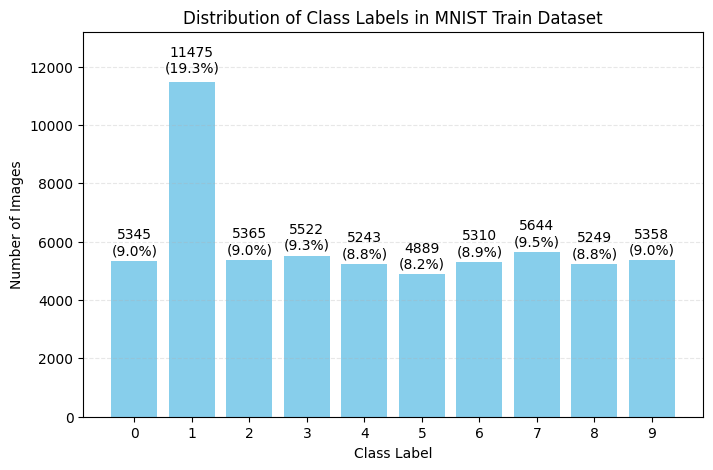

In [7]:
class_counter = Counter()

for _, label in train_dataset:
    class_label = int(label[-1].item())
    class_counter[class_label] += 1

plt.figure(figsize=(8, 5))
bars = plt.bar(class_counter.keys(), class_counter.values(), color='skyblue')

# text annotations above each bar
for bar, count in zip(bars, class_counter.values()):
    percentage = f"{count / sum(class_counter.values()) * 100:.1f}%"
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() / 0.98,
             f"{count}\n({percentage})",
             ha='center', va='bottom')

plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Distribution of Class Labels in MNIST Train Dataset')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.xticks(range(0, 10))
plt.ylim(0, max(class_counter.values()) * 1.15)
plt.show()

In [8]:
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [9]:
def get_bbox(x, y, w, h, img_height=48, img_width=60):
    # convert bounding box format from [center_x, center_y, width, height] to [x_min, y_min, x_max, y_max]
    x_min = (x - w / 2) * img_width
    y_min = (y - h / 2) * img_height
    x_max = (x + w / 2) * img_width
    y_max = (y + h / 2) * img_height
    return [x_min, y_min, x_max, y_max]

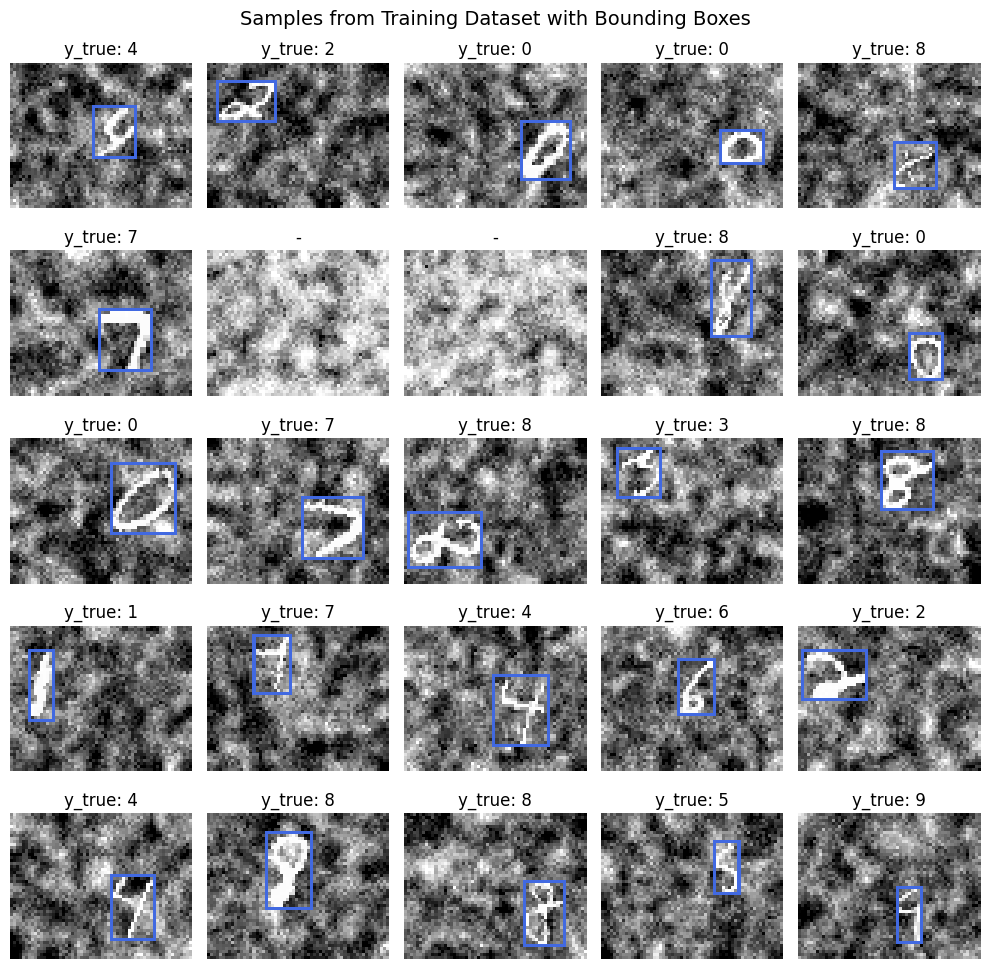

In [206]:
img_height, img_width = 48, 60
sample_indices = np.random.choice(len(train_dataset), 25, replace=False)

# image, bounding box, binary p_c, label
samples = [(train_dataset[idx][0], get_bbox(*train_dataset[idx][1][1:5], img_height, img_width),
            train_dataset[idx][1][0], train_dataset[idx][1][5]) for idx in sample_indices]

fig, axs = plt.subplots(5, 5, figsize=(10, 10))

for ax, (image, bbox, p_c, label) in zip(axs.ravel(), samples):
    img = (image * 255).to(torch.uint8)
    if p_c:
        img = draw_bounding_boxes(img, torch.tensor([bbox], dtype=torch.float), colors="royalblue", width=1)

    ax.imshow(torchvision.transforms.functional.to_pil_image(img), cmap="Greys")
    ax.set_title(f"y_true: {int(label)}" if p_c else "-")
    ax.axis('off')

fig.suptitle("Samples from Training Dataset with Bounding Boxes", fontsize=14)
plt.tight_layout()
plt.show()

2. Implement and train several convolutional models suitable for an object localization task and the data provided.

In [11]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0)
        # Conv1: Input 48x60x1 -> Output 44x56x6
        # (W - K + 2P)/S + 1 = (48-5+2*0)/1 + 1 = 44; (60-5)/1 + 1 = 56

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        # Conv2: Input 22x28x6 -> Output 18x24x16
        # After 2x2 pooling, W and H are halved: 44/2 = 22, 56/2 = 28
        # (22-5+2*0)/1 + 1 = 18; (28-5)/1 + 1 = 24

        # Avg-pooling Layer
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        # Pooling: Reduces the size by half

        self.fc1 = nn.Linear(9 * 12 * 16, 120)
        # FC1: Fully connected layer, the flattened input from Conv2 pooling output is 9*12*16

        self.fc2 = nn.Linear(120, 84)
        # FC2: Second fully connected layer from 120 to 84 neurons

        self.fc3 = nn.Linear(84, num_classes + 5)
        # FC3: Output layer for classification + localization, outputting num_classes + 5

    def forward(self, x):
        # Convolutional and pooling layers sequence
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        # Flattening Conv2 pool output for the fully connected layers
        x = torch.flatten(x, 1)  # Flattening all dimensions except batch

        # Fully connected layers with ReLU activations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [12]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(1, 96, kernel_size=3, stride=1, padding=1)
        # Conv1: Input 48x60x1 -> Output 48x60x96
        # Output: (W - K + 2P)/S + 1 = (48-3+2*1)/1 + 1 = 48; (60-3+2*1)/1 + 1 = 60

        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2)
        # Conv2: Input 24x30x96 (after pooling) -> Output 12x15x256
        # Output size before pooling: (48-5+2*2)/1 + 1 = 48; (60-5+2*2)/1 + 1 = 60
        # After pooling: (24-2)/2 + 1 = 12; (30-2)/2 + 1 = 15

        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1)
        # Conv3: Input 12x15x256 -> Output 12x15x384
        # Output: (12-3+2*1)/1 + 1 = 12; (15-3+2*1)/1 + 1 = 15

        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1)
        # Conv4: Input 12x15x384 -> Output 12x15x384
        # Dimensions remain unchanged (same as Conv3)

        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)
        # Conv5: Input 12x15x384 -> Output 6x7x256
        # Before final pooling, size is the same as input
        # After pooling: (12-2)/2 + 1 = 6; (15-2)/2 + 1 = 7

        # Max-pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Pooling: Halves the dimensions each time it's applied

        # Fully Connected Layers
        # Calculating size after final pooling layer (6x7x256) for the FC layer's input
        self.fc1 = nn.Linear(6 * 7 * 256, 1024)
        # FC1: Flattened inputs from 6x7x256 to 1024 outputs

        self.fc2 = nn.Linear(1024, 1024)
        # FC2: Maintains the size to 1024 outputs

        self.fc3 = nn.Linear(1024, num_classes + 5)
        # FC3: Final layer for classification + localization, outputting num_classes + 5

        # Dropout Layer
        self.dropout = nn.Dropout(0.5)
        # Dropout applied after the first and second FC layers to prevent overfitting

    def forward(self, x):
        # Convolutional and pooling layers sequence
        x = F.relu(self.conv1(x))
        x = self.pool(x)  # After Conv1 and Pool: 24x30x96
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # After Conv2 and Pool: 12x15x256
        x = F.relu(self.conv3(x))  # After Conv3: 12x15x384
        x = F.relu(self.conv4(x))  # After Conv4: 12x15x384
        x = F.relu(self.conv5(x))
        x = self.pool(x)  # After Conv5 and Pool: 6x7x256

        # Flattening before fully connected layers
        x = torch.flatten(x, 1)  # Flattening all dimensions except batch

        # Fully connected layers with ReLU activations and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # Output layer for classification

        return x

In [13]:
def loss_fn(y_pred, y_true):
    # Detection Loss L_A
    detection_loss_fn = nn.BCEWithLogitsLoss()
    detection_loss = detection_loss_fn(y_pred[:, 0], y_true[:, 0])

    # Localization Loss L_B applied conditionally
    localization_loss_fn = nn.MSELoss(reduction='none')
    # calculate element-wise localization loss only for instances where an object is present
    localization_loss = localization_loss_fn(y_pred[:, 1:5], y_true[:, 1:5])
    object_presence = y_true[:, 0].unsqueeze(1)  # ensure it's compatible for element-wise multiplication
    # use torch.where to apply loss only where object is present, else zero loss
    localization_loss = torch.where(object_presence == 1, localization_loss, torch.zeros_like(localization_loss))
    # sum and normalize the localization loss by the number of objects in the batch
    localization_loss = localization_loss.sum() / (object_presence.sum() + 1e-6)

    # Classification Loss L_C applied conditionally
    classification_loss_fn = nn.CrossEntropyLoss(reduction='none')
    # classification loss computed for all, but scaled down to 0 where no object is present
    classification_loss = classification_loss_fn(y_pred[:, 5:], y_true[:, -1].long())
    # apply loss only where object is present
    classification_loss = torch.where(y_true[:, 0] == 1, classification_loss, torch.zeros_like(classification_loss))
    # average the classification loss only over instances with objects
    classification_loss = classification_loss.sum() / (object_presence.sum() + 1e-6)

    # combine all three components of the loss
    total_loss = detection_loss + localization_loss + classification_loss

    return total_loss

In [14]:
def iou(pred_bbox, true_bbox):
    # determine (x,y)-coordinates of the intersection rectangle
    xA = max(pred_bbox[0], true_bbox[0])
    yA = max(pred_bbox[1], true_bbox[1])
    xB = min(pred_bbox[2], true_bbox[2])
    yB = min(pred_bbox[3], true_bbox[3])

    # compute the area of intersection rectangle
    intersection_area = max(0, xB - xA) * max(0, yB - yA)
    # Compute the area of both the prediction and true rectangles
    pred_area = (pred_bbox[2] - pred_bbox[0]) * (pred_bbox[3] - pred_bbox[1])
    true_area = (true_bbox[2] - true_bbox[0]) * (true_bbox[3] - true_bbox[1])

    # compute iou by taking the intersection area and dividing it by 
    # the sum of prediction + ground-truth areas - the intersection area
    iou = intersection_area / float(pred_area + true_area - intersection_area)
    return iou

In [15]:
def calculate_performance(y_pred, y_true):
    # convert detection predictions to binary using sigmoid and thresholding at 0.5
    pred_pc = torch.sigmoid(y_pred[:, 0]) > 0.5
    true_pc = y_true[:, 0] == 1  # True object presence

    # calculate IoU for instances where an object is present
    ious = [iou(get_bbox(*y_pred[i, 1:5]), get_bbox(*y_true[i, 1:5])) for i in range(len(y_true))
            if pred_pc[i] and true_pc[i]]

    # average IoU across all instances with objects
    average_iou = sum(ious) / len(ious) if ious else 0

    # calculate classification accuracy only for detected objects
    correct_classification = (torch.argmax(y_pred[:, 5:], dim=1) == y_true[:, -1]) & pred_pc & true_pc
    # (if the model did not correctly predict the presence of any objects the classification accuracy defaults to 0)
    classification_accuracy = correct_classification.float().mean().item() if true_pc.any() else 0

    # calculate overall performance as the mean of classification accuracy and IoU
    overall_performance = (classification_accuracy + average_iou) / 2

    return classification_accuracy, average_iou, overall_performance

In [16]:
def validate_model(model, val_loader):
    model.eval()
    total_count = 0
    total_classification_accuracy = 0
    total_iou = 0
    total_overall_performance = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            classification_accuracy, iou, overall_performance = calculate_performance(outputs, labels)
            total_classification_accuracy += classification_accuracy
            total_iou += iou
            total_overall_performance += overall_performance
            total_count += 1

    # average the metrics over all validation batches
    avg_classification_accuracy = total_classification_accuracy / total_count
    avg_iou = total_iou / total_count
    avg_overall_performance = total_overall_performance / total_count
    return avg_classification_accuracy, avg_iou, avg_overall_performance

In [17]:
def train_model(model, optimizer, train_loader, val_loader, epochs=10):
    train_losses = []
    overall_performances = []

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0

        for images, labels in train_loader:
            # move data to the appropriate device
            images, labels = images.to(device), labels.to(device)
            # clear the gradients
            optimizer.zero_grad()
            # forward pass: compute the output of the network
            outputs = model(images)
            # compute the loss
            loss = loss_fn(outputs, labels)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # accumulate the loss
            total_loss += loss.item()

        # calculate average loss for the epoch
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # evaluate the model on the validation set
        avg_classification_accuracy, avg_iou, avg_overall_performance = validate_model(model, val_loader)
        overall_performances.append(avg_overall_performance)

        timestamp = datetime.now().strftime('%H:%M:%S.%f')
        print(
            f"{timestamp} | Epoch {epoch} | Training Loss: {avg_loss:.5f} | Overall Performance: {avg_overall_performance:.5f}")

    return train_losses, overall_performances

In [18]:
# model = AlexNet().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# AlexNet_train_losses, AlexNet_overall_performances = train_model(model, optimizer, train_loader, val_loader, epochs=1)

In [19]:
n_epochs = 20
lenet5_model = LeNet5().to(device)
optimizer = torch.optim.Adam(lenet5_model.parameters(), lr=0.001)
lenet5_train_losses, lenet5_overall_performances = train_model(lenet5_model, optimizer, train_loader, val_loader,
                                                               epochs=n_epochs)

18:54:14.259127 | Epoch 1 | Training Loss: 2.65461 | Overall Performance: 0.28154
18:54:35.508327 | Epoch 2 | Training Loss: 2.21684 | Overall Performance: 0.35864
18:54:56.769430 | Epoch 3 | Training Loss: 2.09796 | Overall Performance: 0.32200
18:55:18.270594 | Epoch 4 | Training Loss: 2.06489 | Overall Performance: 0.32316
18:55:39.686861 | Epoch 5 | Training Loss: 2.03277 | Overall Performance: 0.37882
18:56:00.893757 | Epoch 6 | Training Loss: 2.00146 | Overall Performance: 0.37523
18:56:22.086487 | Epoch 7 | Training Loss: 1.96812 | Overall Performance: 0.38204
18:56:43.284861 | Epoch 8 | Training Loss: 1.92752 | Overall Performance: 0.39893
18:57:04.493937 | Epoch 9 | Training Loss: 1.89536 | Overall Performance: 0.35275
18:57:25.682415 | Epoch 10 | Training Loss: 1.84840 | Overall Performance: 0.40449
18:57:47.288880 | Epoch 11 | Training Loss: 1.78858 | Overall Performance: 0.39729
18:58:08.588505 | Epoch 12 | Training Loss: 1.72251 | Overall Performance: 0.40104
18:58:30.0956

In [20]:
def plot_model_performance(epochs, train_losses, overall_performances, model_name):
    plt.figure(figsize=(12, 5))
    plt.suptitle(f'{model_name} Performance', fontsize=15)

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', color='cornflowerblue')
    plt.title(f'Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(0, epochs + 1, 5))
    plt.legend()
    plt.grid(color='silver', linestyle='--', linewidth=0.5)

    plt.subplot(1, 2, 2)
    plt.plot(overall_performances, label='Overall Performance', color='yellowgreen')
    plt.title(f'Overall Performance over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Performance')
    plt.xticks(range(0, epochs + 1, 5))
    plt.legend()
    plt.grid(color='silver', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()

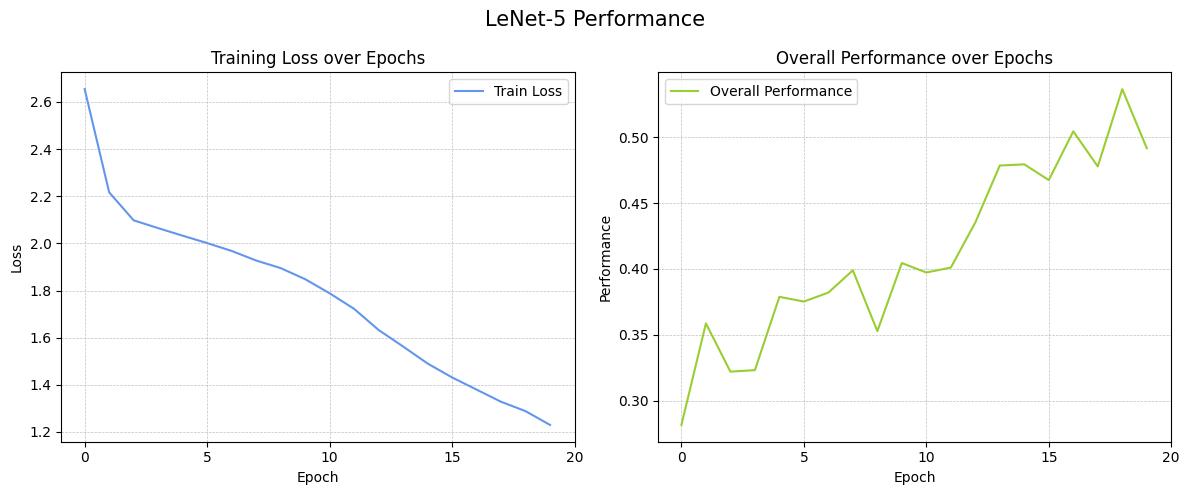

In [21]:
plot_model_performance(n_epochs, lenet5_train_losses, lenet5_overall_performances, model_name="LeNet-5")

In [22]:
def plot_model_predictions(model, dataset, model_name="", img_height=48, img_width=60):
    model.eval()
    sample_indices = np.random.choice(len(dataset), 25, replace=False)
    fig, axs = plt.subplots(5, 5, figsize=(10, 10))
    axs = axs.ravel()

    with torch.no_grad():
        for i, idx in enumerate(sample_indices):
            sample = dataset[idx]
            img, y_true = sample
            img_tensor = img.unsqueeze(0).to(device)  # add batch dimension and move to device
            y_pred = model(img_tensor)

            true_p_c = y_true[0].item()
            pred_p_c = torch.sigmoid(y_pred[0, 0]).item() > 0.5  # predicted object presence

            boxes, colors = [], []

            # if true object is present, add its bbox to the list
            if true_p_c:
                true_bbox = get_bbox(*y_true[1:5], img_height, img_width)
                boxes.append(true_bbox)
                colors.append("limegreen")  # true bbox in green

            # if model predicts an object, add its bbox to the list
            if pred_p_c:
                pred_bbox = get_bbox(*y_pred[0, 1:5].cpu().numpy(), img_height, img_width)
                boxes.append(pred_bbox)
                colors.append("crimson")  # predicted bbox in red

            img = (img * 255).to(torch.uint8)  # prepare image
            if boxes:  # only draw boxes if the list is not empty
                img = draw_bounding_boxes(
                    img,
                    torch.tensor(boxes, dtype=torch.float).int(),
                    colors=colors,
                    width=1
                )

            axs[i].imshow(torchvision.transforms.functional.to_pil_image(img), cmap="Greys")
            true_class = int(y_true[5].item())
            pred_class = torch.argmax(y_pred[0, 5:]).item()
            axs[i].set_title(f"true: {true_class} / pred: {pred_class}" if pred_p_c else "-")
            axs[i].axis('off')

    fig.suptitle(f"{model_name}\nTrue vs. Predicted Outcomes", fontsize=15)
    plt.tight_layout()
    plt.show()

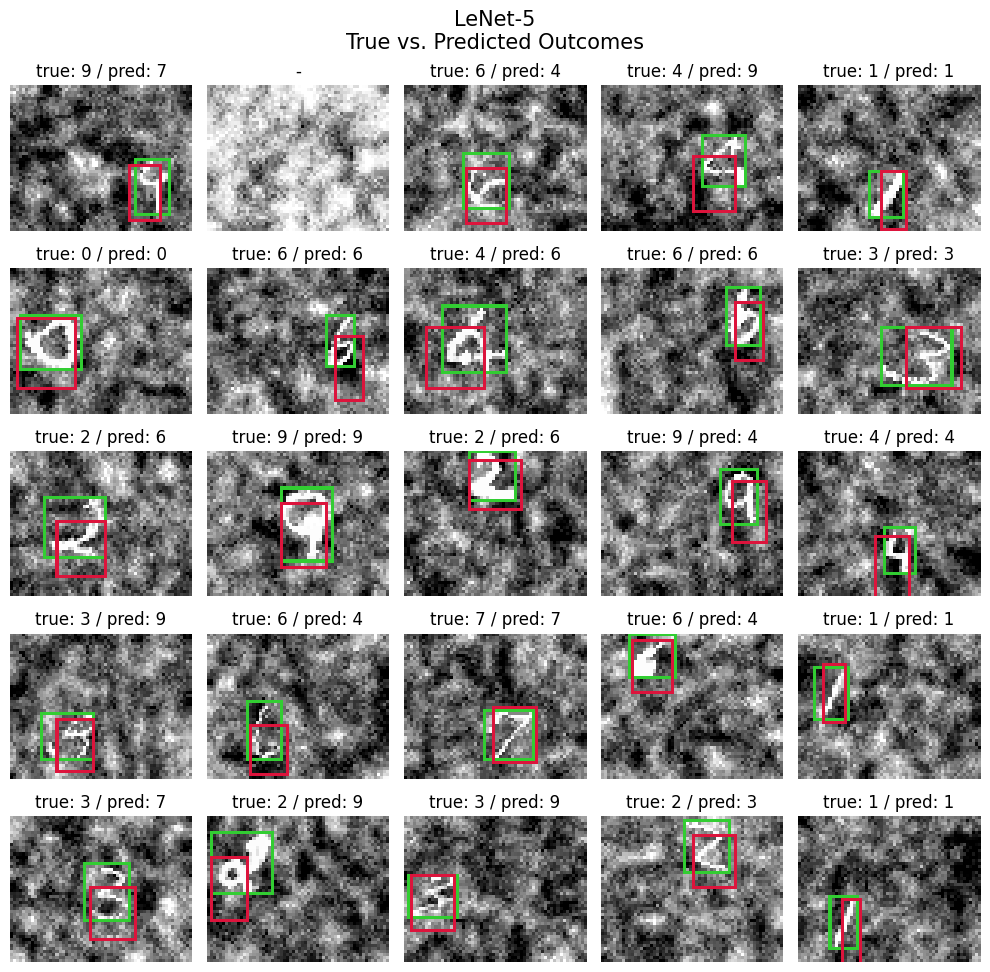

In [23]:
plot_model_predictions(lenet5_model, train_dataset, model_name="LeNet-5")

# 3. Object Detection

3.1.1 Data preparation of `y_true`

In [217]:
list_y_true_train = torch.load('data/list_y_true_train.pt')
list_y_true_val = torch.load('data/list_y_true_val.pt')
list_y_true_test = torch.load('data/list_y_true_test.pt')

In [218]:
detection_train = torch.load('data/detection_train.pt')
detection_val = torch.load('data/detection_val.pt')
detection_test = torch.load('data/detection_test.pt')

In [219]:
def assign_to_grid(y_true, H_out=2, W_out=3):
    grid = torch.zeros((H_out, W_out, 6))
    cell_width = 1.0 / W_out
    cell_height = 1.0 / H_out

    for obj in y_true:
        # calculate the cell index for x and y
        cell_x = int(obj[1] // cell_width)
        cell_y = int(obj[2] // cell_height)

        # normalize x and y to the cell: find the relative position within the cell
        obj[1] = (obj[1] % cell_width) / cell_width
        obj[2] = (obj[2] % cell_height) / cell_height

        # adjust width and height based on grid size
        obj[3] /= cell_width
        obj[4] /= cell_height

        # place the object tensor in the correct grid cell
        grid[cell_y, cell_x] = obj

    return grid


detection_y_true_train = [assign_to_grid(list_y_true) for list_y_true in list_y_true_train]

In [220]:
# original list of lists of tensors of shape 6
list_y_true_train[0]

[tensor([1.0000, 0.7750, 0.8125, 0.3500, 0.7917, 1.0000]),
 tensor([1.0000, 0.9500, 0.3333, 0.7000, 0.6667, 0.0000])]

In [221]:
# processed list_y_true_train for a 2×3 grid
detection_y_true_train[0]

tensor([[[1.0000, 0.7750, 0.8125, 0.3500, 0.7917, 1.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.9500, 0.3333, 0.7000, 0.6667, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]])

In [222]:
# compare with already processed (N, H, W, 6) tensor from detection_train dataset
# procedure was successful, the grids are identical ✔️
detection_train[0][1]

tensor([[[1.0000, 0.7750, 0.8125, 0.3500, 0.7917, 1.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.9500, 0.3333, 0.7000, 0.6667, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]])

In [223]:
# extract images from detection_train
detection_img_train = list(map(lambda x: x[0], detection_train))

In [226]:
def get_bbox_in_grid(x, y, w, h, grid_row, grid_col, img_height=48, img_width=60, grid_rows=2, grid_cols=3):
    # calculate the dimensions of each grid cell
    cell_height = img_height / grid_rows
    cell_width = img_width / grid_cols
    
    # calculate the top left corner of the grid cell
    cell_x_min = grid_col * cell_width
    cell_y_min = grid_row * cell_height
    
    # convert bounding box format from [center_x, center_y, width, height] to [x_min, y_min, x_max, y_max]
    x_min = cell_x_min + (x - w / 2) * cell_width
    y_min = cell_y_min + (y - h / 2) * cell_height
    x_max = cell_x_min + (x + w / 2) * cell_width
    y_max = cell_y_min + (y + h / 2) * cell_height
    
    return [x_min, y_min, x_max, y_max]

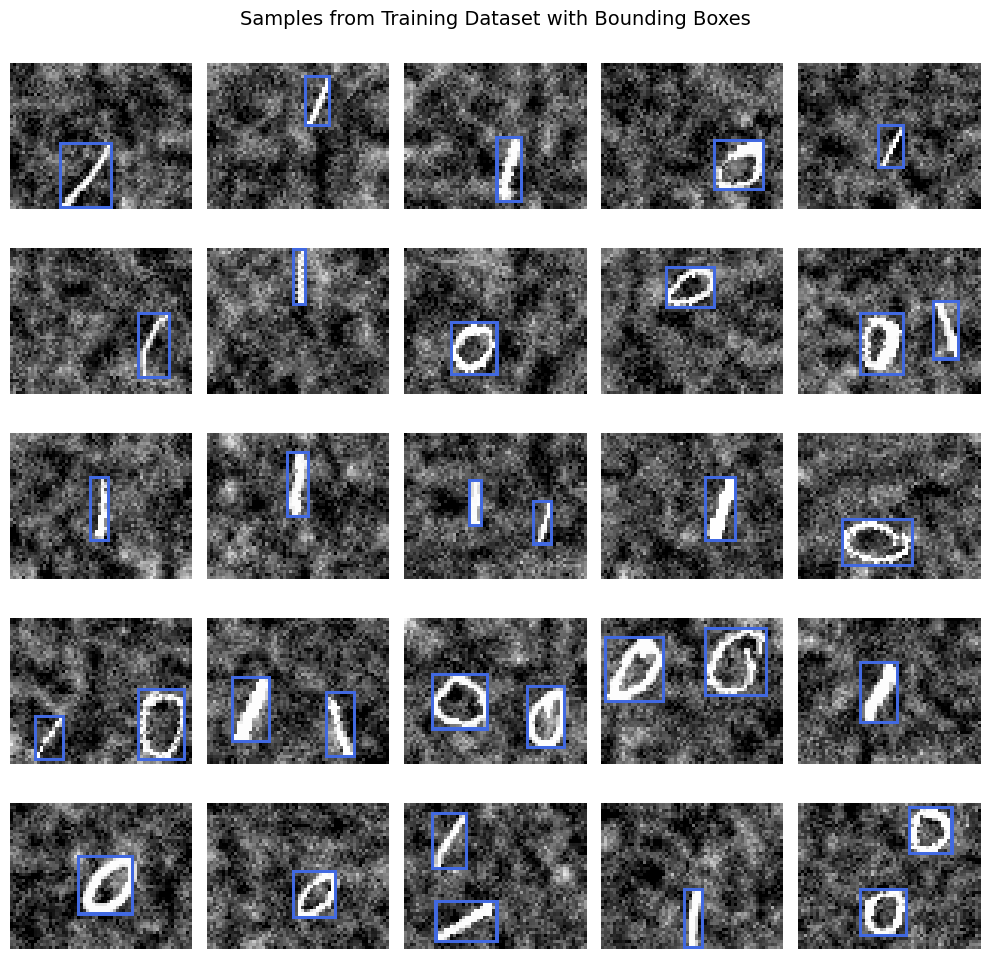

In [227]:
sample_indices = np.random.choice(len(detection_y_true_train), 25, replace=False)
fig, axs = plt.subplots(5, 5, figsize=(10, 10))

for ax, idx in zip(axs.ravel(), sample_indices):
    img = (detection_img_train[idx] * 255).to(torch.uint8)
    for row, y_true_list in enumerate(detection_y_true_train[idx]):
        for col, (p_c, x, y, w, h, c) in enumerate(y_true_list):
            if p_c == 1:
                bbox = get_bbox_in_grid(x, y, w, h, row, col)
                img = draw_bounding_boxes(img, torch.tensor([bbox], dtype=torch.float), colors="royalblue", width=1)

    ax.imshow(torchvision.transforms.functional.to_pil_image(img), cmap="Greys")
    ax.axis('off')

fig.suptitle("Samples from Training Dataset with Bounding Boxes", fontsize=14)
plt.tight_layout()
plt.show()